In [9]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
# filter out the warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
cascades_path = '/usr/share/opencv/haarcascades/'
face_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cascades_path + 'haarcascade_eye.xml')

In [11]:
import time

def current_time():
    return int(round(time.time() * 1000))

def get_right_left_eyes(roi_gray):
    # sort descending
    eyes = eye_cascade.detectMultiScale(roi_gray)
    eyes_sorted_by_size = sorted(eyes, key=lambda x: -x[2])
    largest_eyes = eyes_sorted_by_size[:2]
    # sort by x position
    largest_eyes.sort(key=lambda x: x[0])
    return largest_eyes

def extract_face_features(face, img, gray):
    [x,y,w,h] = face
    roi_gray = gray[y:y+h, x:x+w]
    face_image = np.copy(img[y:y+h, x:x+w])
    
    eyes = get_right_left_eyes(roi_gray)
    eye_images = []
    for (ex,ey,ew,eh) in eyes:
        eye_images.append(np.copy(img[y+ey:y+ey+eh,x+ex:x+ex+ew]))
                
    roi_color = img[y:y+h, x:x+w]
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        
    
    return face_image, eye_images

def get_face_grid(face, frameW, frameH, gridSize):
    faceX,faceY,faceW,faceH = face

    return faceGridFromFaceRect(frameW, frameH, gridSize, gridSize, faceX, faceY, faceW, faceH, False)

def extract_image_features(full_img_path):
    img = cv2.imread(full_img_path)
    start_ms = current_time()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_detections = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    faces = []
    face_features = []
    for [x,y,w,h] in face_detections:
        face = [x, y, w, h]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        face_image, eye_images = extract_face_features(face, img, gray)
        face_grid = get_face_grid(face, img.shape[1], img.shape[0], 25)
        
        faces.append(face)
        face_features.append([face_image, eye_images, face_grid])
    
    duration_ms = current_time() - start_ms
    print("Face and eye extraction took: ", str(duration_ms / 1000) + "s")
    
    return img, faces, face_features

gridSize = 25

In [12]:
img, faces, face_features = extract_image_features('../appleFace00002/00000.jpg')

Face and eye extraction took:  0.13s


In [13]:
# This code is converted from https://github.com/CSAILVision/GazeCapture/blob/master/code/faceGridFromFaceRect.m

# Given face detection data, generate face grid data.
#
# Input Parameters:
# - frameW/H: The frame in which the detections exist
# - gridW/H: The size of the grid (typically same aspect ratio as the
#     frame, but much smaller)
# - labelFaceX/Y/W/H: The face detection (x and y are 0-based image
#     coordinates)
# - parameterized: Whether to actually output the grid or just the
#     [x y w h] of the 1s square within the gridW x gridH grid.

def faceGridFromFaceRect(frameW, frameH, gridW, gridH, labelFaceX, labelFaceY, labelFaceW, labelFaceH, parameterized):

    scaleX = gridW / frameW
    scaleY = gridH / frameH
    
    if parameterized:
      labelFaceGrid = np.zeros(4)
    else:
      labelFaceGrid = np.zeros(gridW * gridH)
    
    grid = np.zeros((gridH, gridW))

    # Use one-based image coordinates.
    xLo = round(labelFaceX * scaleX)
    yLo = round(labelFaceY * scaleY)
    w = round(labelFaceW * scaleX)
    h = round(labelFaceH * scaleY)

    if parameterized:
        labelFaceGrid = [xLo, yLo, w, h]
    else:
        xHi = xLo + w
        yHi = yLo + h

        # Clamp the values in the range.
        xLo = int(min(gridW, max(0, xLo)))
        xHi = int(min(gridW, max(0, xHi)))
        yLo = int(min(gridH, max(0, yLo)))
        yHi = int(min(gridH, max(0, yHi)))

        faceLocation = np.ones((yHi - yLo, xHi - xLo))
        grid[yLo:yHi, xLo:xHi] = faceLocation

        # Flatten the grid.
        grid = np.transpose(grid)
        labelFaceGrid = grid.flatten()
        
    return labelFaceGrid
      

In [14]:
def set_title_and_hide_axis(title):
    plt.title(title)
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)

def render_face_grid(face_grid):
    to_print = np.copy(face_grid)
    result_image = np.copy(to_print).reshape(25, 25).transpose()
    plt.figure()
    set_title_and_hide_axis('Face grid')
#     print(result_image.shape)
    plt.imshow(result_image)

def show_extraction_results(img, faces, face_features):
    plt.figure(figsize=(10,10))
    set_title_and_hide_axis('Original image and extracted features')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation="bicubic")

    for i, face in enumerate(faces):
        print('Face #' + str(i))
        #print('i', face, i)
        face_image, eye_images, face_grid = face_features[i]
        plt.figure()
        set_title_and_hide_axis('Extracted face image')
        plt.imshow(cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")
        plt.figure()
        #print('face image after extraction')
        render_face_grid(face_grid)

        for eye_image in eye_images:
            plt.figure()

            #print('eye image after extraction')
            set_title_and_hide_axis('Extracted eye image')
            plt.imshow(cv2.cvtColor(eye_image, cv2.COLOR_BGR2RGB), interpolation="bicubic")

In [15]:
img, faces, face_features = extract_image_features('../appleFace00002/00000.jpg')

Face and eye extraction took:  0.038s


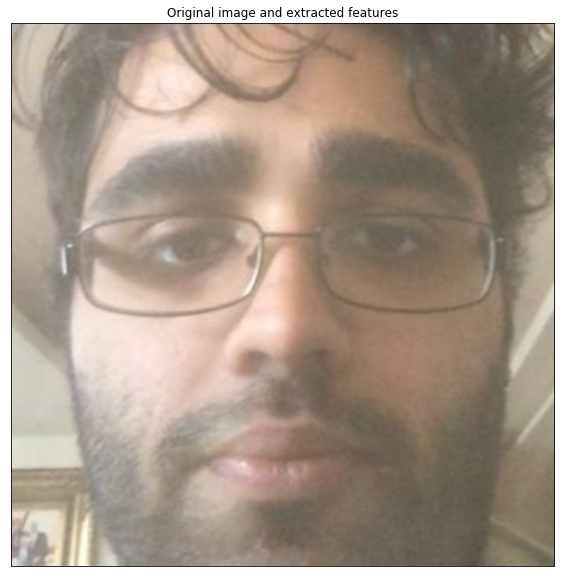

In [17]:
show_extraction_results(img, faces, face_features)

In [7]:
import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
def load_graph(frozen_graph_filename):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
#     with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
#         graph_def = tf.GraphDef()
#         graph_def.ParseFromString(f.read())
    with tf.Session(graph=tf.Graph()) as sess:
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], "./")
    return sess.graph

In [8]:
import os
# We use our "load_graph" function
graph = load_graph('saved_model.pb')

# We can verify that we can access the list of operations in the graph
for op in graph.get_operations():
    print(op.name)

# We access the input and output nodes 
# x = graph.get_tensor_by_name('prefix/Placeholder/inputs_placeholder:0')
# y = graph.get_tensor_by_name('prefix/Accuracy/predictions:0')
        
# We launch a Session
#with tf.Session(graph=graph) as sess:
    # Note: we don't nee to initialize/restore anything
    # There is no Variables in this graph, only hardcoded constants 
    #y_out = sess.run(y, feed_dict={
     #   x: [[3, 5, 7, 4, 5, 1, 1, 1, 1, 1]] # < 45
    #})
    # I taught a neural net to recognise when a sum of numbers is bigger than 45
    # it should return False in this case
#print(y_out) # [[ False ]] Yay, it works!

INFO:tensorflow:Restoring parameters from b'./variables/variables'
save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/ShardedFilename/shard
save/num_shards
save/StringJoin/inputs_1
save/Const
save/RestoreV2
save/StringJoin
save/ShardedFilename
dense_6/bias
save/Assign_36
dense_6/bias/read
dense_6/bias/Initializer/Const
dense_6/bias/Assign
dense_6/kernel
save/Assign_37
dense_6/kernel/read
dense_6/kernel/Initializer/Const
dense_6/kernel/Assign
Flatten_7/flatten/Reshape/shape/1
Flatten_7/flatten/strided_slice/stack_2
Flatten_7/flatten/strided_slice/stack_1
Flatten_7/flatten/strided_slice/stack
dense_5/bias
save/Assign_34
dense_5/bias/read
dense_5/bias/Initializer/Const
dense_5/bias/Assign
dense_5/kernel
save/Assign_35
dense_5/kernel/read
dense_5/kernel/Initializer/Const
dense_5/kernel/Assign
Flatten_6/flatten/Reshape/shape/1
Flatten_6/flatten/strided_slice/stack_2
Flatten_6/flatten/strided_slice/stack_1
Flatten_6/flatten/